In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from glob import glob
import numpy as np
import nibabel as nib
import os
import pickle
from torch.utils.data import Dataset
from torchvision import transforms
from torch.autograd import Function, Variable
from tqdm import tqdm
import math

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
torch.cuda.get_device_name()

'GeForce GTX 1660 Ti'

In [4]:
class single_conv(nn.Module):
    def __init__(self, inchan, outchan):
        super(single_conv, self).__init__()
        self.relu = nn.ReLU()
        self.conv = nn.Conv3d(inchan, outchan, kernel_size=5, padding=2)
        self.bn = nn.BatchNorm3d(outchan)

    def forward(self, x):
        out = self.relu(self.bn(self.conv(x)))
        return out


In [5]:
class input_layer(nn.Module):
    def __init__(self, inchan, outchan):
        super(single_conv, self).__init__()
        self.relu = nn.ReLU()
        self.conv = nn.Conv3d(inchan, outchan, kernel_size=5, padding=2)
        self.bn = nn.BatchNorm3d(outchan)

    def forward(self, x):
        out = self.relu(self.bn(self.conv(x)))
        return out
    

In [6]:
class down(nn.Module):
    def __init__(self):
        super(down, self).__init__()
        self.down = nn.MaxPool3d((2,2,2)) 
    def forward(self, x):
        x = self.down(x)
        return x

In [7]:
class up(nn.Module):
    def __init__(self):
        super(up, self).__init__()
        self.up = nn.Upsample(scale_factor = 2, mode = 'trilinear') # use nn.Upsample() with mode bilinear
    def forward(self, x1, x2): # Takes in smaller x1 and larger x2
        # First we upsample x1 to be same size as x2
        x1 = self.up(x1)
        # This part is tricky so we've completed this
        # Notice that x2 and x1 may not have the same spatial size.
        # This is because when you downsample old_x2(say 25 by 25), you will get x1(12 by 12)
        # Then you perform upsample to x1, you will get new_x1(24 by 24) 3/26/2020 CA04_UNet_TEMPLATEfile:///Users/admin/Downloads/CA04_UNet_TEMPLATE.html 4/29
        # You should pad a new row and column so that new_x1 and x2 have the same size.
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]
        diffZ = x2.size()[4] - x1.size()[4]
        x1 = F.pad(x1, (diffX // 2, diffX - diffX//2, diffY // 2, diffY - diffY//2, diffZ // 2, diffZ - diffZ//2))
        # Now we concatenat x2 and x1 along channel dimension: torch.cat()
        # Note pytorch tensor shape correspond to: (batchsize, channel, x_dim, y_dim)
        x = torch.cat((x2,x1),1)
        return x

In [8]:
class outconv(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(outconv, self).__init__()
        # 1 conv layer
        self.conv = nn.Conv3d(in_ch, out_ch, kernel_size = 1)
    def forward(self, x):
        #x = np.pad(x, ((0,2),(0,2),(0,2)), 'constant')
        x = self.conv(x)
        # Apply sigmoid activation: torch.sigmoid()
        x = torch.sigmoid(x)
        return x



In [9]:
class UNet(nn.Module):
    def __init__(self):
        super(UNet, self).__init__()
        ## Define the necessary layers using the classes defined above
        self.conv_1_16 = single_conv(1,16)
        self.down = down()
        self.up = up()
        self.conv_16_32 = single_conv(16,32)
        self.conv_32_32 = single_conv(32,32)
        self.conv_64_16 = single_conv(64,16)
        self.conv_32_16 = single_conv(32,16)
        self.outconv = outconv(16,1)
        
    def forward(self, x):
        # Define forward pass
        x1 = self.conv_1_16(x)
        #print(x1.shape) 
        x1d = self.down(x1)
        #print(x1d.shape)
        x2 = self.conv_16_32(x1d)
        #print(x2.shape)
        x2d = self.down(x2)
        #print(x2d.shape)
        x3 = self.conv_32_32(x2d)
        #print(x3.shape)
        x4 = self.up(x3,x2)
        #print(x4.shape)
        x5 = self.conv_64_16(x4)
        #print(x5.shape)
        x6 = self.up(x5,x1)
        #print(x6.shape)
        x7 = self.conv_32_16(x6)
        #print(x7.shape)
        x = self.outconv(x7)
        #print(x.shape)
        return x

In [10]:
net = UNet()
#print(model)

In [11]:
n_params = sum(p.numel() for p in net.parameters() if p.requires_grad)
print('Number of parameters in network: ', n_params)

Number of parameters in network:  386353


In [12]:
# Path to the folder that contains folders of segmentation data
PATH = "data/TrainingDataset_MSSEG/*/"
IPATH = "data/Pre-processed training dataset/*/"
# Takes all folders in the path 
image_paths = []
mask_paths = []

block_size = (32,32,32)

for path in glob(PATH):
    # Load all the paths for each Flair set of data (1 Flair data and all its segmentation paths)
    seg1_path = path + 'Consensus.nii.gz'
    mask_paths.extend([seg1_path])
    
for path in glob(IPATH):
    flair_path = path + 'FLAIR_preprocessed.nii.gz'
    image_paths.extend([flair_path])
#print(image_paths)
#print(mask_paths)

In [13]:
def split_train_val(image_paths, mask_paths, train_size):
    img_paths_dic = {}
    mask_paths_dic = {}
    len_data = len(image_paths)
    print('total len:', len_data)
    p = 0
    q = 0
    for i in range(len(image_paths)):
        img_paths_dic[str(p)+'_'+str(q)] = image_paths[i]
        if q==6:
            q=0
            p=p+1
        else:
            q=q+1
    
    p = 0
    q = 0
    for i in range(len(mask_paths)):
        mask_paths_dic[str(p)+'_'+str(q)] = mask_paths[i]
        if q==6:
            q=0
            p=p+1
        else:
            q=q+1
        
    img_mask_list = []
    #print(img_paths_dic)
    
    for key in img_paths_dic:
        img_mask_list.append((img_paths_dic[key], mask_paths_dic[key]))
        
    train_img_mask_paths = img_mask_list[:int(len_data*train_size)] 
    test_img_mask_paths = img_mask_list[int(len_data*train_size):]
    return train_img_mask_paths, test_img_mask_paths



In [14]:
def zero_padding(data, block_size):
    # Calculate final size to be achieved
    ceil_val = math.ceil(data.shape[0]/block_size[0])
    #Calculate required padding size 
    pad_val_c = (block_size[0] * ceil_val) - data.shape[0]
    
    # Calculate final size to be achieved
    ceil_val = math.ceil(data.shape[1]/block_size[1])
    #Calculate required padding size
    pad_val_h = (block_size[1] * ceil_val) - data.shape[1]
    
    # Calculate final size to be achieved
    ceil_val = math.ceil(data.shape[2]/block_size[2])
    # Calculate required padding size
    pad_val_w = (block_size[2] * ceil_val) - data.shape[2]
    
    # Constant padding
    #data = data.numpy()
    data = np.pad(data, ((0,pad_val_c),(0,pad_val_h),(0,pad_val_w)), 'constant')
    #data = np.array(data, dtype=np.int16)
    
    #changed dtype to float
    data = np.array(data, dtype=np.float32)
    return data


def get_data_blocks(data, block_size ):
    x = torch.from_numpy(data)
    # Add a dimension at 0th position
    x = x.unsqueeze(0)
    # Kernel Size
    kc, kh, kw = block_size[0], block_size[1], block_size[2]
    # stride
    dc, dh, dw = block_size[0], block_size[1], block_size[2]
    patches = x.unfold(1, kc, dc).unfold(2, kh, dh).unfold(3, kw, dw)
    unfold_shape = patches.size()
    patches = patches.contiguous().view(patches.size(0), -1, kc, kh, kw)
    #Return Patches and Unfold Shape
    return patches, unfold_shape

In [15]:
imagesize = (48,96,96)
def preprocess_image(image_mask_paths):
    img_mask_list = []

    for i in tqdm(range(len(image_mask_paths))):
        vol = nib.load(image_mask_paths[i][0])
        m = nib.load(image_mask_paths[i][1])
        img = np.array(vol.get_data(), np.float32)
        #img_padded = np.pad(img, ((0,2),(0,2),(0,2)), 'constant')
        mask = np.array(m.get_data(),np.float32)
        #mask_padded = mask
        img = nn.functional.interpolate(torch.from_numpy(img).unsqueeze(0).unsqueeze(0), size=imagesize, mode='trilinear')
        img = img / torch.max(img)
        mask = nn.functional.interpolate(torch.from_numpy(mask).unsqueeze(0).unsqueeze(0), size=imagesize, mode='trilinear')
        mask = mask / torch.max(mask)
        mask[mask > 0.5] = 1
        mask[mask <= 0.5] = 0
        img_mask_list.append((img.squeeze().squeeze().numpy(),mask.squeeze().squeeze().numpy()))
    return img_mask_list
    '''#mask_padded = zero_padding(mask, block_size)

        # Generate data blocks of block_size
        img_blocks, unfold_shape_img = get_data_blocks(data = img_padded, block_size = block_size)
        mask_blocks, unfold_shape_mask = get_data_blocks(data = mask_padded, block_size = block_size)

        img_array = img_blocks.numpy()
        mask_array = mask_blocks.numpy()
        per_img = []
        per_mask = []
        if i<1:
            for j in range(len(img_array[0])):
                #if np.sum(mask_array[0][j])>0:
                img_mask_list.append((img_array[0][j], mask_array[0][j]))
                #print(img_array[0][i].shape)
        else:
            for j in range(len(img_array[0])):
                #if np.sum(mask_array[0][j])>0:
                img_mask_list.append((img_array[0][j], mask_array[0][j]))

    return img_mask_list '''

In [16]:
train_img_mask_paths, test_img_mask_paths = split_train_val(image_paths, mask_paths, 0.8)

print(train_img_mask_paths)
#Training:
train_img_masks = preprocess_image(train_img_mask_paths)

#Validation:
test_img_masks = preprocess_image(test_img_mask_paths)

  0%|          | 0/12 [00:00<?, ?it/s]

total len: 15
[('data/Pre-processed training dataset\\01016SACH\\FLAIR_preprocessed.nii.gz', 'data/TrainingDataset_MSSEG\\01016SACH\\Consensus.nii.gz'), ('data/Pre-processed training dataset\\01038PAGU\\FLAIR_preprocessed.nii.gz', 'data/TrainingDataset_MSSEG\\01038PAGU\\Consensus.nii.gz'), ('data/Pre-processed training dataset\\01039VITE\\FLAIR_preprocessed.nii.gz', 'data/TrainingDataset_MSSEG\\01039VITE\\Consensus.nii.gz'), ('data/Pre-processed training dataset\\01040VANE\\FLAIR_preprocessed.nii.gz', 'data/TrainingDataset_MSSEG\\01040VANE\\Consensus.nii.gz'), ('data/Pre-processed training dataset\\01042GULE\\FLAIR_preprocessed.nii.gz', 'data/TrainingDataset_MSSEG\\01042GULE\\Consensus.nii.gz'), ('data/Pre-processed training dataset\\07001MOEL\\FLAIR_preprocessed.nii.gz', 'data/TrainingDataset_MSSEG\\07001MOEL\\Consensus.nii.gz'), ('data/Pre-processed training dataset\\07003SATH\\FLAIR_preprocessed.nii.gz', 'data/TrainingDataset_MSSEG\\07003SATH\\Consensus.nii.gz'), ('data/Pre-processe

100%|██████████| 3/3 [00:04<00:00,  1.57s/it]


In [17]:
print(len(train_img_masks))

12


In [18]:
class ToTensor(object):
    """
    Convert ndarrays in sample to Tensors.
    """
    def __init__(self):
        pass

    def __call__(self, sample):
        image, label = sample['img'], sample['label']
        image = image[None,:,:]
        label = label[None,:,:]
#         image = image.numpy()
#         label = label.numpy()
        return {'img': torch.from_numpy(image.copy()).type(torch.FloatTensor),
                'label': torch.from_numpy(label.copy()).type(torch.FloatTensor)}

In [19]:
class CustomDataset(Dataset):
    def __init__(self, image_masks, transforms=None):

        self.image_masks = image_masks
        self.transforms = transforms

    def __len__(self):  # return count of sample we have

        return len(self.image_masks)

    def __getitem__(self, index):

        image = self.image_masks[index][0] # H, W, C
        mask = self.image_masks[index][1]

#         image = np.transpose(image, axes=[2, 0, 1]) # C, H, W

        sample = {'img': image, 'label': mask}

        if transforms:
            sample = self.transforms(sample)

        return sample
train_dataset = []
validation_dataset = []
for i in range(len(train_img_masks)):
    train_dataset.append(CustomDataset(train_img_masks[:i]+train_img_masks[i+1:], transforms=transforms.Compose([ToTensor()])))
    validation_dataset.append(CustomDataset([train_img_masks[i]], transforms=transforms.Compose([ToTensor()])))
test_dataset = CustomDataset(test_img_masks, transforms=transforms.Compose([ToTensor()]))

In [20]:

# define dice coefficient 
class DiceCoeff(Function):
    """Dice coeff for one pair of input image and target image"""
    def forward(self, prediction, target):
        self.save_for_backward(prediction, target)
        eps = 0.0001 # in case union = 0
        # Calculate intersection and union. 
        # You can convert the input image into a vector with input.contiguous().view(-1)
        # Then use torch.dot(A, B) to calculate the intersection.
        A = prediction.contiguous().view(-1)
        B = target.contiguous().view(-1)
        inter = torch.dot(A.float(),B.float())
        #print("inter", inter)
        union = torch.sum(A.float()) + torch.sum(B.float()) - inter + eps
        #print("union", union)
        # Calculate DICE 
        d = inter / union
        #print("d", d)
        return d

# Calculate dice coefficients for batches
def dice_coeff(prediction, target):
    """Dice coeff for batches"""
    s = torch.FloatTensor(1).zero_()
    
    # For each pair of input and target, call DiceCoeff().forward(prediction, target) to calculate dice coefficient
    # Then average
    for i, (a,b) in enumerate(zip(prediction, target)):
        s += DiceCoeff().forward(a,b)
    s = s / (i + 1)
    return s

def dice_loss(prediction, target):
    eps = 0.0001 # in case union = 0
    A = prediction
    B = target
    inter = torch.dot(A.float(),B.float())
    union = torch.sum(A.float()) + torch.sum(B.float()) - inter + eps
    d = inter / union
    #print("d", d)
    return 1-d

In [21]:
def eval_net(net, dataset):
    # set net mode to evaluation
    net.eval()
    tot = 0
    print("val dataset length:", len(dataset))
    for i, b in enumerate(dataset):
        img = b['img'].to(device)
        B = img.shape[0]
        true_mask = b['label'].to(device)

        # Feed the image to the network to get predicted mask
        mask_pred = net(img.float())

        # For all pixels in predicted mask, set them to 1 if larger than 0.5. Otherwise set them to 0
        #mask_pred[mask_pred > 0.5] = 1
        #mask_pred[mask_pred <= 0.5] = 0
        #print("maskpred", type(mask_pred), mask_pred.shape)
        #print("true", type(true_mask), true_mask.shape)
        # calculate dice_coeff()
        # note that you should add all the dice_coeff in validation/testing dataset together
        # call dice_coeff() here
        #masks_probs_flat = mask_pred.flatten()
        #true_masks_flat = true_mask.flatten()
        
        #tot += dice_coeff(true_masks_flat,masks_probs_flat)
        tot += dice_coeff(true_mask,mask_pred)
        # Return average dice_coeff()
    return tot / (i + 1)


In [22]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [23]:
from torch import optim
epochs = 500 # e.g. 10, or more until dice converge
batch_size = 3 # e.g. 16
lr = 0.04      # e.g. 0.01
N_train = len(train_img_masks)
model_save_path = 'model/'  # directory to same the model after each epoch.
optimizer = optim.Adam(net.parameters(),lr = lr, weight_decay=0.0005)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=(N_train*N_train), gamma=0.5)
criterion = nn.BCELoss()
net.to(device)
# Start training
for epoch in range(epochs):
    print('Starting epoch {}/{}.'.format(epoch + 1, epochs))
    net.train()
    val_index = (epoch//len(train_dataset))%len(train_dataset)
    # Reload images and masks for training and validation and perform random shuffling at the begining of each epoch
    train_loader = torch.utils.data.DataLoader(train_dataset[val_index], batch_size=batch_size, shuffle=False, num_workers=0)
    validation_loader = torch.utils.data.DataLoader(validation_dataset[val_index], batch_size=batch_size, shuffle=False, num_workers=0)

    epoch_loss = 0
    count = 0

    for i, b in enumerate(train_loader):
        # Get images and masks from each batch

        imgs = b['img'].to(device)
        true_masks = b['label'].to(device)
        #print('True mask shape: ',true_masks.shape, type(true_masks))
        #print('images shape:', imgs.shape, type(imgs))
        # Feed your images into the network
        masks_pred = net.forward(imgs.float())
        #print('Predicted mask shape: ',masks_pred.shape)
        #masks_pred = nn.functional.interpolate(masks_pred, size=true_masks.shape, mode='bilinear')
        # Flatten the predicted masks and true masks. For example, A_flat = A.view(-1)
        #masks_probs_flat = masks_pred.view(-1)
        #true_masks_flat = true_masks.view(-1)
        #print('true_masks: ',true_masks.shape)
        #print('masks_pred: ',masks_pred.shape)
        masks_probs = masks_pred
        
        #masks_probs_flat = np.transpose(masks_probs_flat, axes=[1, 0, 2, 3, 4])
        #masks_probs_flat = masks_probs_flat[0]
        #masks_probs_flat = masks_probs.view(masks_probs.numel())
        #true_masks_flat = true_masks.view(true_masks.numel())
        
        masks_probs_flat = masks_probs.flatten()
        true_masks_flat = true_masks.flatten()
        # Calculate the loss by comparing the predicted masks vector and true masks vector
        # And sum the losses together
        loss = dice_loss(masks_probs_flat,true_masks_flat)
        epoch_loss += loss.item()
        if count % 100 == 0:
            print('{0:.4f} --- loss: {1:.6f}'.format(i * batch_size / N_train, loss.item()))
        count = count + 1
        # optimizer.zero_grad() clears x.grad for every parameter x in the optimizer.
        # It’s important to call this before loss.backward(), otherwise you’ll accumulate the gradients from multiple passes.
        optimizer.zero_grad()
        # loss.backward() computes dloss/dx for every parameter x which has requires_grad=True.
        # These are accumulated into x.grad for every parameter x
        loss.backward()
        # optimizer.step updates the value of x using the gradient x.grad.
        optimizer.step()
    print('Epoch finished ! Loss: {}'.format(epoch_loss / (i+1)))

    # Perform validation with eval_net() on the validation data
    val_dice = eval_net(net,validation_loader)
    print('Validation Dice Coeff: {}'.format(val_dice))
    scheduler.step()
    print("lr", optimizer.param_groups[0]['lr'])
    # Save the model after each epoch
    '''if os.path.isdir(model_save_path):
        torch.save(net.state_dict(),model_save_path + 'Brain_Seg_Epoch{}.pth'.format(epoch + 1))
    else:
        os.makedirs(model_save_path, exist_ok=True)
        torch.save(net.state_dict(),model_save_path + 'Brain_Seg_Epoch{}.pth'.format(epoch + 1))
    print('Checkpoint {} saved !'.format(epoch + 1))'''


Starting epoch 1/500.
0.0000 --- loss: 0.997996
Epoch finished ! Loss: 0.9977483153343201
val dataset length: 1
Validation Dice Coeff: tensor([0.0077], grad_fn=<DivBackward0>)
lr 0.04
Starting epoch 2/500.
0.0000 --- loss: 0.996570
Epoch finished ! Loss: 0.9975185936147516
val dataset length: 1
Validation Dice Coeff: tensor([0.0069], grad_fn=<DivBackward0>)
lr 0.04
Starting epoch 3/500.
0.0000 --- loss: 0.996651
Epoch finished ! Loss: 0.9968931133096869
val dataset length: 1
Validation Dice Coeff: tensor([0.0069], grad_fn=<DivBackward0>)
lr 0.04
Starting epoch 4/500.
0.0000 --- loss: 0.995365
Epoch finished ! Loss: 0.995952541177923
val dataset length: 1
Validation Dice Coeff: tensor([0.0166], grad_fn=<DivBackward0>)
lr 0.04
Starting epoch 5/500.
0.0000 --- loss: 0.992747
Epoch finished ! Loss: 0.9925314133817499
val dataset length: 1
Validation Dice Coeff: tensor([0.0055], grad_fn=<DivBackward0>)
lr 0.04
Starting epoch 6/500.
0.0000 --- loss: 0.984148
Epoch finished ! Loss: 0.98356705

Epoch finished ! Loss: 0.9544597593220797
val dataset length: 1
Validation Dice Coeff: tensor([9.6735e-08], grad_fn=<DivBackward0>)
lr 0.04
Starting epoch 46/500.
0.0000 --- loss: 0.989346
Epoch finished ! Loss: 0.9629175066947937
val dataset length: 1
Validation Dice Coeff: tensor([0.0001], grad_fn=<DivBackward0>)
lr 0.04
Starting epoch 47/500.
0.0000 --- loss: 0.867957
Epoch finished ! Loss: 0.9807978651740334
val dataset length: 1
Validation Dice Coeff: tensor([7.7810e-05], grad_fn=<DivBackward0>)
lr 0.04
Starting epoch 48/500.
0.0000 --- loss: 0.991005
Epoch finished ! Loss: 0.9770782698284496
val dataset length: 1
Validation Dice Coeff: tensor([2.3660e-05], grad_fn=<DivBackward0>)
lr 0.04
Starting epoch 49/500.
0.0000 --- loss: 0.881404
Epoch finished ! Loss: 0.9705301956696943
val dataset length: 1
Validation Dice Coeff: tensor([4.5931e-05], grad_fn=<DivBackward0>)
lr 0.04
Starting epoch 50/500.
0.0000 --- loss: 0.894964
Epoch finished ! Loss: 0.9703945625912059
val dataset lengt

Epoch finished ! Loss: 0.9660589911720969
val dataset length: 1
Validation Dice Coeff: tensor([4.8773e-06], grad_fn=<DivBackward0>)
lr 0.04
Starting epoch 90/500.
0.0000 --- loss: 0.922866
Epoch finished ! Loss: 0.9479127743027427
val dataset length: 1
Validation Dice Coeff: tensor([0.0017], grad_fn=<DivBackward0>)
lr 0.04
Starting epoch 91/500.
0.0000 --- loss: 0.859686
Epoch finished ! Loss: 0.9780284599824385
val dataset length: 1
Validation Dice Coeff: tensor([7.9975e-05], grad_fn=<DivBackward0>)
lr 0.04
Starting epoch 92/500.
0.0000 --- loss: 0.923809
Epoch finished ! Loss: 0.9770628918300975
val dataset length: 1
Validation Dice Coeff: tensor([4.8811e-05], grad_fn=<DivBackward0>)
lr 0.04
Starting epoch 93/500.
0.0000 --- loss: 0.902878
Epoch finished ! Loss: 0.9681338451125405
val dataset length: 1
Validation Dice Coeff: tensor([8.5307e-05], grad_fn=<DivBackward0>)
lr 0.04
Starting epoch 94/500.
0.0000 --- loss: 0.857264
Epoch finished ! Loss: 0.9571177580139854
val dataset lengt

Epoch finished ! Loss: 0.9957466288046404
val dataset length: 1
Validation Dice Coeff: tensor([0.0011], grad_fn=<DivBackward0>)
lr 0.04
Starting epoch 134/500.
0.0000 --- loss: 0.850797
Epoch finished ! Loss: 0.9360079223459418
val dataset length: 1
Validation Dice Coeff: tensor([0.0012], grad_fn=<DivBackward0>)
lr 0.04
Starting epoch 135/500.
0.0000 --- loss: 0.911910
Epoch finished ! Loss: 0.9502543319355358
val dataset length: 1
Validation Dice Coeff: tensor([0.0004], grad_fn=<DivBackward0>)
lr 0.04
Starting epoch 136/500.
0.0000 --- loss: 0.888267
Epoch finished ! Loss: 0.946678492155942
val dataset length: 1
Validation Dice Coeff: tensor([1.3561e-05], grad_fn=<DivBackward0>)
lr 0.04
Starting epoch 137/500.
0.0000 --- loss: 0.862561
Epoch finished ! Loss: 0.954214789650657
val dataset length: 1
Validation Dice Coeff: tensor([7.0998e-06], grad_fn=<DivBackward0>)
lr 0.04
Starting epoch 138/500.
0.0000 --- loss: 0.855146
Epoch finished ! Loss: 0.9435279857028614
val dataset length: 1


Epoch finished ! Loss: 0.9249844984574751
val dataset length: 1
Validation Dice Coeff: tensor([2.0082e-05], grad_fn=<DivBackward0>)
lr 0.02
Starting epoch 178/500.
0.0000 --- loss: 0.834121
Epoch finished ! Loss: 0.9224815639582548
val dataset length: 1
Validation Dice Coeff: tensor([5.0445e-06], grad_fn=<DivBackward0>)
lr 0.02
Starting epoch 179/500.
0.0000 --- loss: 0.845778
Epoch finished ! Loss: 0.9172362143343146
val dataset length: 1
Validation Dice Coeff: tensor([5.0576e-06], grad_fn=<DivBackward0>)
lr 0.02
Starting epoch 180/500.
0.0000 --- loss: 0.867721
Epoch finished ! Loss: 0.9204521179199219
val dataset length: 1
Validation Dice Coeff: tensor([3.2413e-06], grad_fn=<DivBackward0>)
lr 0.02
Starting epoch 181/500.
0.0000 --- loss: 0.864837
Epoch finished ! Loss: 0.9060388749296014
val dataset length: 1
Validation Dice Coeff: tensor([1.9331e-06], grad_fn=<DivBackward0>)
lr 0.02
Starting epoch 182/500.
0.0000 --- loss: 0.865285
Epoch finished ! Loss: 0.904329549182545
val datas

Epoch finished ! Loss: 0.8910701058127664
val dataset length: 1
Validation Dice Coeff: tensor([0.0001], grad_fn=<DivBackward0>)
lr 0.02
Starting epoch 222/500.
0.0000 --- loss: 0.825812
Epoch finished ! Loss: 0.8890034556388855
val dataset length: 1
Validation Dice Coeff: tensor([2.2953e-06], grad_fn=<DivBackward0>)
lr 0.02
Starting epoch 223/500.
0.0000 --- loss: 0.817413
Epoch finished ! Loss: 0.8900465911084955
val dataset length: 1
Validation Dice Coeff: tensor([0.1059], grad_fn=<DivBackward0>)
lr 0.02
Starting epoch 224/500.
0.0000 --- loss: 0.868777
Epoch finished ! Loss: 0.895679154179313
val dataset length: 1
Validation Dice Coeff: tensor([6.1356e-06], grad_fn=<DivBackward0>)
lr 0.02
Starting epoch 225/500.
0.0000 --- loss: 0.809589
Epoch finished ! Loss: 0.8987827084281228
val dataset length: 1
Validation Dice Coeff: tensor([0.0712], grad_fn=<DivBackward0>)
lr 0.02
Starting epoch 226/500.
0.0000 --- loss: 0.842074
Epoch finished ! Loss: 0.9031664295630022
val dataset length: 1

Epoch finished ! Loss: 0.882834028113972
val dataset length: 1
Validation Dice Coeff: tensor([0.0826], grad_fn=<DivBackward0>)
lr 0.02
Starting epoch 266/500.
0.0000 --- loss: 0.817871
Epoch finished ! Loss: 0.8825586438179016
val dataset length: 1
Validation Dice Coeff: tensor([0.0904], grad_fn=<DivBackward0>)
lr 0.02
Starting epoch 267/500.
0.0000 --- loss: 0.868516
Epoch finished ! Loss: 0.8924700997092507
val dataset length: 1
Validation Dice Coeff: tensor([3.9420e-06], grad_fn=<DivBackward0>)
lr 0.02
Starting epoch 268/500.
0.0000 --- loss: 0.804332
Epoch finished ! Loss: 0.8794116648760709
val dataset length: 1
Validation Dice Coeff: tensor([0.0961], grad_fn=<DivBackward0>)
lr 0.02
Starting epoch 269/500.
0.0000 --- loss: 0.816321
Epoch finished ! Loss: 0.8713620684363625
val dataset length: 1
Validation Dice Coeff: tensor([0.0003], grad_fn=<DivBackward0>)
lr 0.02
Starting epoch 270/500.
0.0000 --- loss: 0.999861
Epoch finished ! Loss: 0.9999854564666748
val dataset length: 1
Val

Epoch finished ! Loss: 0.9288214228369973
val dataset length: 1
Validation Dice Coeff: tensor([0.0960], grad_fn=<DivBackward0>)
lr 0.01
Starting epoch 310/500.
0.0000 --- loss: 0.792183
Epoch finished ! Loss: 0.9312688274817034
val dataset length: 1
Validation Dice Coeff: tensor([0.0952], grad_fn=<DivBackward0>)
lr 0.01
Starting epoch 311/500.
0.0000 --- loss: 0.782043
Epoch finished ! Loss: 0.9213592355901544
val dataset length: 1
Validation Dice Coeff: tensor([6.0590e-06], grad_fn=<DivBackward0>)
lr 0.01
Starting epoch 312/500.
0.0000 --- loss: 0.973169
Epoch finished ! Loss: 0.9487028013576161
val dataset length: 1
Validation Dice Coeff: tensor([0.0466], grad_fn=<DivBackward0>)
lr 0.01
Starting epoch 313/500.
0.0000 --- loss: 0.869214
Epoch finished ! Loss: 0.9545446851036765
val dataset length: 1
Validation Dice Coeff: tensor([0.0465], grad_fn=<DivBackward0>)
lr 0.01
Starting epoch 314/500.
0.0000 --- loss: 0.838652
Epoch finished ! Loss: 0.9510063529014587
val dataset length: 1
Va

Validation Dice Coeff: tensor([0.0016], grad_fn=<DivBackward0>)
lr 0.01
Starting epoch 354/500.
0.0000 --- loss: 0.740455
Epoch finished ! Loss: 0.8838701735843312
val dataset length: 1
Validation Dice Coeff: tensor([0.0039], grad_fn=<DivBackward0>)
lr 0.01
Starting epoch 355/500.
0.0000 --- loss: 0.901437
Epoch finished ! Loss: 0.9274573542855002
val dataset length: 1
Validation Dice Coeff: tensor([0.0014], grad_fn=<DivBackward0>)
lr 0.01
Starting epoch 356/500.
0.0000 --- loss: 0.860300
Epoch finished ! Loss: 0.9185254898938265
val dataset length: 1
Validation Dice Coeff: tensor([0.0027], grad_fn=<DivBackward0>)
lr 0.01
Starting epoch 357/500.
0.0000 --- loss: 0.774411
Epoch finished ! Loss: 0.8930096572095697
val dataset length: 1
Validation Dice Coeff: tensor([0.0034], grad_fn=<DivBackward0>)
lr 0.01
Starting epoch 358/500.
0.0000 --- loss: 0.828306
Epoch finished ! Loss: 0.8892029903151772
val dataset length: 1
Validation Dice Coeff: tensor([0.0039], grad_fn=<DivBackward0>)
lr 0.0

Epoch finished ! Loss: 0.839674787087874
val dataset length: 1
Validation Dice Coeff: tensor([0.0226], grad_fn=<DivBackward0>)
lr 0.01
Starting epoch 399/500.
0.0000 --- loss: 0.574701
Epoch finished ! Loss: 0.7719234011389993
val dataset length: 1
Validation Dice Coeff: tensor([0.0174], grad_fn=<DivBackward0>)
lr 0.01
Starting epoch 400/500.
0.0000 --- loss: 0.522725
Epoch finished ! Loss: 0.7622288194569674
val dataset length: 1
Validation Dice Coeff: tensor([0.0162], grad_fn=<DivBackward0>)
lr 0.01
Starting epoch 401/500.
0.0000 --- loss: 0.952327
Epoch finished ! Loss: 0.8907285874540155
val dataset length: 1
Validation Dice Coeff: tensor([0.0136], grad_fn=<DivBackward0>)
lr 0.01
Starting epoch 402/500.
0.0000 --- loss: 0.538710
Epoch finished ! Loss: 0.8085622733289545
val dataset length: 1
Validation Dice Coeff: tensor([0.0301], grad_fn=<DivBackward0>)
lr 0.01
Starting epoch 403/500.
0.0000 --- loss: 0.511111
Epoch finished ! Loss: 0.7580174316059459
val dataset length: 1
Validat

Validation Dice Coeff: tensor([0.2475], grad_fn=<DivBackward0>)
lr 0.005
Starting epoch 443/500.
0.0000 --- loss: 0.604846
Epoch finished ! Loss: 0.6741068959236145
val dataset length: 1
Validation Dice Coeff: tensor([0.3141], grad_fn=<DivBackward0>)
lr 0.005
Starting epoch 444/500.
0.0000 --- loss: 0.606155
Epoch finished ! Loss: 0.6889839497479525
val dataset length: 1
Validation Dice Coeff: tensor([0.6061], grad_fn=<DivBackward0>)
lr 0.005
Starting epoch 445/500.
0.0000 --- loss: 0.414897
Epoch finished ! Loss: 0.6650676835667003
val dataset length: 1
Validation Dice Coeff: tensor([0.0002], grad_fn=<DivBackward0>)
lr 0.005
Starting epoch 446/500.
0.0000 --- loss: 0.443043
Epoch finished ! Loss: 0.6599501263011586
val dataset length: 1
Validation Dice Coeff: tensor([0.0396], grad_fn=<DivBackward0>)
lr 0.005
Starting epoch 447/500.
0.0000 --- loss: 0.452912
Epoch finished ! Loss: 0.6531602957031943
val dataset length: 1
Validation Dice Coeff: tensor([4.1622e-05], grad_fn=<DivBackward0

Validation Dice Coeff: tensor([0.0137], grad_fn=<DivBackward0>)
lr 0.005
Starting epoch 487/500.
0.0000 --- loss: 0.443274
Epoch finished ! Loss: 0.6528268944133412
val dataset length: 1
Validation Dice Coeff: tensor([0.2258], grad_fn=<DivBackward0>)
lr 0.005
Starting epoch 488/500.
0.0000 --- loss: 0.430888
Epoch finished ! Loss: 0.6513156619938937
val dataset length: 1
Validation Dice Coeff: tensor([0.0468], grad_fn=<DivBackward0>)
lr 0.005
Starting epoch 489/500.
0.0000 --- loss: 0.437029
Epoch finished ! Loss: 0.649152701551264
val dataset length: 1
Validation Dice Coeff: tensor([0.3339], grad_fn=<DivBackward0>)
lr 0.005
Starting epoch 490/500.
0.0000 --- loss: 0.421852
Epoch finished ! Loss: 0.6415618549693715
val dataset length: 1
Validation Dice Coeff: tensor([0.1345], grad_fn=<DivBackward0>)
lr 0.005
Starting epoch 491/500.
0.0000 --- loss: 0.428016
Epoch finished ! Loss: 0.6432239684191617
val dataset length: 1
Validation Dice Coeff: tensor([0.3319], grad_fn=<DivBackward0>)
lr

In [24]:
def predict_img(net,full_img,out_threshold=0.5):
    # set the mode of your network to evaluation
    net.eval()

    # convert from Height*Width*Channel TO Channel*Height*Width
    #full_img = np.transpose(full_img,[2,0,1])

    # convert numpy array to torch tensor, normalize to range (0,1)
    #full_img = full_img/np.amax(full_img)
    print(full_img.shape)
    X_img = full_img.to(device)
    print(X_img.shape)

    with torch.no_grad():

        output_img = net(X_img.float())
        #out_probs = output_img.squeeze(0).squeeze(0)
        masks_probs = output_img.mean(0) # removes channel
        masks_probs = masks_probs[0] # consider output[0]
        # threshold the probability to generate mask: mask=1 if prob > out_threshold, set mask to uint8
        out_mask_np = (masks_probs>out_threshold).cpu().numpy().astype('uint8')

    return out_mask_np

In [25]:
def reconstruct(blocks, unfold_shape):

    blocks_orig = blocks.view(unfold_shape)
    output_c = unfold_shape[1] * unfold_shape[4]
    output_h = unfold_shape[2] * unfold_shape[5]
    output_w = unfold_shape[3] * unfold_shape[6]
    blocks_orig = blocks_orig.permute(0, 1, 4, 2, 5, 3, 6).contiguous()
    blocks_orig = blocks_orig.view(1, output_c, output_h, output_w)
    # Remove the dimension at 0th position and convert to numpy
    blocks_orig = blocks_orig.squeeze(0).detach().numpy()
    return blocks_orig

In [26]:
# Load an image from testing dataset
test_img_paths = "data/Pre-processed training dataset/08029IVDI/FLAIR_preprocessed.nii.gz"
test_mask_paths = "data/TrainingDataset_MSSEG/08029IVDI/Consensus.nii.gz"
vol = nib.load(test_img_paths)
vol_affine = vol.affine
m = nib.load(test_mask_paths)
img = np.array(vol.get_data(), np.float32)
img = nn.functional.interpolate(torch.from_numpy(img).unsqueeze(0).unsqueeze(0), size=imagesize, mode='trilinear')
img = img/torch.max(img)
#img_padded = zero_padding(img, block_size)
mask_orig = np.array(m.get_data(), np.float32)
mask_orig = mask_orig/np.amax(mask_orig)
mask_orig = nn.functional.interpolate(torch.from_numpy(mask_orig).unsqueeze(0).unsqueeze(0), size=imagesize, mode='trilinear')
mask_orig[mask_orig > 0.5] = 1
mask_orig[mask_orig <= 0.5] = 0
#mask_padded = zero_padding(mask, block_size)
mask_recon = predict_img(net=net,full_img=img, out_threshold=0.00005)
'''
# Generate data blocks of block_size
img_blocks, unfold_shape_img = get_data_blocks(data = img_padded, block_size = block_size)
#mask_blocks, unfold_shape_mask = get_data_blocks(data = mask_padded, block_size = block_size)

img_array = img_blocks.numpy()
test_img = []


for i in range(len(img_array[0])):
    test_img.append(img_array[0][i])
#test_img_mask = preprocess_image(test_img_paths)

orig_shape = len(test_img)
print(len(test_img))

#img_resize = cv2.resize(test_img_mask,(100,80))
predicted = []
for image in test_img:

    # Predict the mask
    mask_pred = predict_img(net=net,full_img=image, out_threshold=0.5)
    # Rescale the mask back to original image size
    #print(mask_pred.shape)
    predicted.append(mask_pred)

pred = torch.from_numpy(np.asarray(predicted)).type(torch.FloatTensor)
mask_recon = reconstruct(pred,unfold_shape_img)
'''

torch.Size([1, 1, 48, 96, 96])
torch.Size([1, 1, 48, 96, 96])


'\n# Generate data blocks of block_size\nimg_blocks, unfold_shape_img = get_data_blocks(data = img_padded, block_size = block_size)\n#mask_blocks, unfold_shape_mask = get_data_blocks(data = mask_padded, block_size = block_size)\n\nimg_array = img_blocks.numpy()\ntest_img = []\n\n\nfor i in range(len(img_array[0])):\n    test_img.append(img_array[0][i])\n#test_img_mask = preprocess_image(test_img_paths)\n\norig_shape = len(test_img)\nprint(len(test_img))\n\n#img_resize = cv2.resize(test_img_mask,(100,80))\npredicted = []\nfor image in test_img:\n\n    # Predict the mask\n    mask_pred = predict_img(net=net,full_img=image, out_threshold=0.5)\n    # Rescale the mask back to original image size\n    #print(mask_pred.shape)\n    predicted.append(mask_pred)\n\npred = torch.from_numpy(np.asarray(predicted)).type(torch.FloatTensor)\nmask_recon = reconstruct(pred,unfold_shape_img)\n'

In [27]:

#Segment
mask_recon = torch.from_numpy(np.asarray(mask_recon)).type(torch.FloatTensor)
#mask_interpolated = nn.functional.interpolate(mask_recon.unsqueeze(0).unsqueeze(0), size=img.shape, mode='trilinear')
img_seg = mask_recon #* img
img_seg = img_seg.squeeze().squeeze().numpy()
img_seg_original = mask_orig.squeeze().squeeze().numpy()#*img
img = img.squeeze().squeeze().numpy()
#img = img.numpy()
print(type(img_seg), img_seg.shape)
print(img.shape)
print(img_seg_original.shape)


import matplotlib.pyplot as plt
def show_slices(slices):
    """ Function to display row of image slices """
    fig, axes = plt.subplots(1, len(slices), figsize=(10,5))
    for i, slice in enumerate(slices):
        axes[i].imshow(slice.T, cmap="gray", origin="lower")

<class 'numpy.ndarray'> (48, 96, 96)
(48, 96, 96)
(48, 96, 96)


Text(0.5, 0.98, 'Center slices for MRI image')

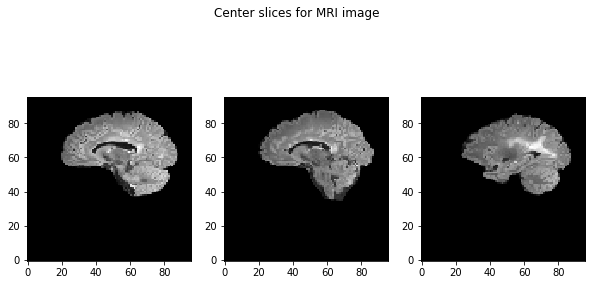

In [28]:
slice_0 = img[20, :, :]
slice_1 = img[25, :, :]
slice_2 = img[30, :, :]
show_slices([slice_0, slice_1, slice_2])
plt.suptitle("Center slices for MRI image")

Text(0.5, 0.98, 'Center slices for MRI image segmented by prediction')

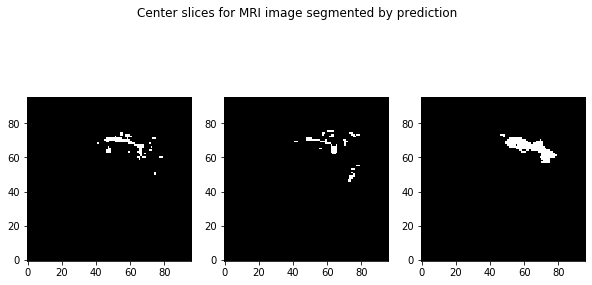

In [29]:
slice_0 = img_seg[20, :, :]
slice_1 = img_seg[25, :, :]
slice_2 = img_seg[30, :, :]
show_slices([slice_0, slice_1, slice_2])
plt.suptitle("Center slices for MRI image segmented by prediction")

Text(0.5, 0.98, 'Center slices for MRI image segmented original')

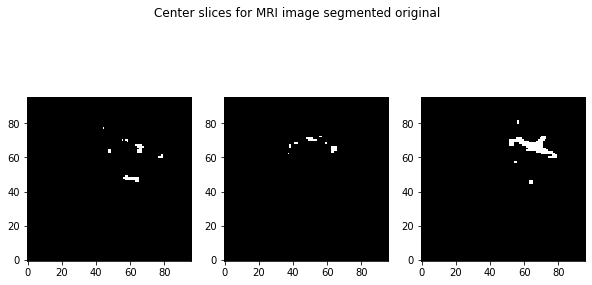

In [30]:
slice_0 = img_seg_original[20, :, :]
slice_1 = img_seg_original[25, :, :]
slice_2 = img_seg_original[30, :, :]
show_slices([slice_0, slice_1, slice_2])
plt.suptitle("Center slices for MRI image segmented original")

In [31]:
print(img_seg_original.shape, np.sum(img_seg_original), np.amax(img_seg_original))
print(img_seg.shape, np.sum(img_seg), np.amax(img_seg))
print(img.shape, np.sum(img), np.amax(img))
print(1-dice_loss(torch.from_numpy(img_seg.flatten()), torch.from_numpy(img_seg_original.flatten())))
print(test_img_mask_paths)

(48, 96, 96) 1446.0 1.0
(48, 96, 96) 3051.0 1.0
(48, 96, 96) 22355.861 1.0
tensor(0.3211)
[('data/Pre-processed training dataset\\08029IVDI\\FLAIR_preprocessed.nii.gz', 'data/TrainingDataset_MSSEG\\08029IVDI\\Consensus.nii.gz'), ('data/Pre-processed training dataset\\08031SEVE\\FLAIR_preprocessed.nii.gz', 'data/TrainingDataset_MSSEG\\08031SEVE\\Consensus.nii.gz'), ('data/Pre-processed training dataset\\08037ROGU\\FLAIR_preprocessed.nii.gz', 'data/TrainingDataset_MSSEG\\08037ROGU\\Consensus.nii.gz')]


In [32]:
print(optimizer.param_groups[0]['lr'])

0.005
